<a href="https://colab.research.google.com/github/kushagraagrawal/Thales_AIChallenge/blob/master/Thales_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile
with zipfile.ZipFile('gdrive/My Drive/Colab Notebooks/DataChallenge.zip', 'r') as zip_ref:
    zip_ref.extractall('dataChallenge')

In [0]:
!pip install tifffile
!pip3 install torch torchvision

    100% |████████████████████████████████| 133kB 5.9MB/s 


In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tifffile as tiff

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [0]:
train_df = pd.read_csv('dataChallenge/DataChallenge/descriptions_training.csv', header=None, 
                           names = ["nb_spots", 
                                    "x_first_spot", "y_first_spot",
                                    "x_second_spot", "y_second_spot"])
print(train_df.head())
n = 4
img_name = train_df.iloc[n, 0]
train = train_df.iloc[n, 2:].as_matrix()
#train = train.astype('float').reshape(-1, 2)
print(train.shape)
print(train_df.shape)
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(train.shape))
print('First 4 Landmarks: {}'.format(train[:4]))

   nb_spots  x_first_spot  y_first_spot  x_second_spot  y_second_spot
0         1     18.877351     16.573234            0.0            0.0
1         1     10.159097     15.718106            0.0            0.0
2         1      9.441056     14.829910            0.0            0.0
3         0      0.000000      0.000000            0.0            0.0
4         0      0.000000      0.000000            0.0            0.0
(3,)
(209933, 5)
Image name: 0
Landmarks shape: (3,)
First 4 Landmarks: [0. 0. 0.]


In [0]:
scan = []

scan = tiff.imread("dataChallenge/DataChallenge/images_training.tiff")

In [0]:
class SpotDetectionDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.train_df = pd.read_csv(csv_file, header=None, names = ["nb_spots", 
                                    "x_first_spot", "y_first_spot",
                                    "x_second_spot", "y_second_spot"])
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.train_df)
  
  def __getitem__(self, idx):
#     print(scan[idx].shape)
 #   image = scan[idx,:,:,0]
#     image = transforms.ToPILImage()(image)
    image = scan[idx]
    spots = self.train_df.iloc[idx, 1:5].as_matrix()
    spots = spots.astype('float').reshape(-1, 2)
    sample = {'image': image, 'spots': spots}
    if self.transform:
      sample = self.transform(sample)
    
    return sample   
    
    

In [0]:
def show_spots(image, spots):
    """Show image with landmarks"""
    print
    plt.imshow(image)
    plt.scatter(spots[:, 0], spots[:, 1], s=4, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


0 (24, 24, 3) (2, 2)


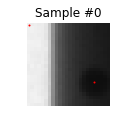

1 (24, 24, 3) (2, 2)


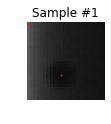

2 (24, 24, 3) (2, 2)


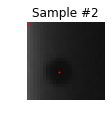

3 (24, 24, 3) (2, 2)


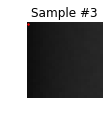

In [89]:
spot_dataset = SpotDetectionDataset(csv_file='dataChallenge/DataChallenge/descriptions_training.csv',
                                    root_dir='dataChallenge/DataChallenge/images_training.tiff')

fig = plt.figure()

for i in range(len(spot_dataset)):
    sample = spot_dataset[i]

    print(i, sample['image'].shape, sample['spots'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_spots(**sample)

    if i == 3:
        plt.show()
        break

0 torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 2])
1 torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 2])
2 torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 2])
3 torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 2])


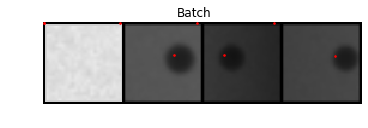

In [93]:
transformed_dataset = SpotDetectionDataset(csv_file='dataChallenge/DataChallenge/descriptions_training.csv',
                                    root_dir='dataChallenge/DataChallenge/images_training.tiff',
                                          transform=transforms.Compose([
                                              Rescale(64),
                                               ToTensor()
                                           ]))

dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


def show_spots_batch(sample_batched):
  images_batch, spots_batch = sample_batched['image'], sample_batched['spots']
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1,2,0)))
  
  for i in range(batch_size):
    plt.scatter(spots_batch[i,:,0].numpy() + i * im_size,
               spots_batch[i,:,1].numpy(),
               s=10, marker='.', c='r')
    plt.title('Batch')

for i_batch, sample_batched in enumerate(dataloader):
  print(i_batch, sample_batched['image'].size(),
       sample_batched['spots'].size())
  if i_batch == 3:
    plt.figure()
    show_spots_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break
  

### Not adding Transformations for now, work on simple dataset

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, spots = sample['image'], sample['spots']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        spots = spots * [new_w / w, new_h / h]

        return {'image': img, 'spots': spots}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, spots = sample['image'], sample['spots']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        spots = spots - [left, top]

        return {'image': image, 'spots': spots}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, spots = sample['image'], sample['spots']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'spots': torch.from_numpy(spots)}

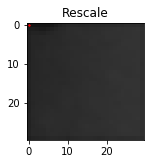

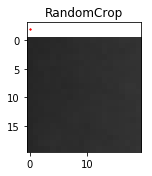

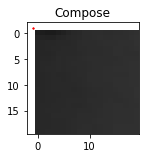

In [0]:
scale = Rescale(30)
crop = RandomCrop(20)
composed = transforms.Compose([Rescale(30),
                               RandomCrop(20)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = spot_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_spots(**transformed_sample)

plt.show()

In [0]:
trn_trnsfms = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

tst_trnsfms = transforms.Compose([
    transforms.Resize((24, 24)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [0]:
transformed_dataset = SpotDetectionDataset(csv_file='dataChallenge/DataChallenge/descriptions_training.csv',
                                           root_dir='dataChallenge/DataChallenge/images_training.tiff',
                                          transform=trn_trnsfms)

# transformed_dataset = trn_trnsfms(transforms.ToPILImage()(transformed_dataset))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    sample['image'] = transforms.ToPILImage()(sample['image'])
    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

TypeError: ignored

In [0]:
# def read_images(nameFile):
#     """
#     Return a list of images present in the .tiff file named 
#     `nameFile` in the Data folder
#     """
#     dataImages = []
#     scan = []
#     try:
#         scan = tiff.imread("dataChallenge/DataChallenge/"+nameFile) # load the images
#     except:
#         print("ERROR: file Data/" + nameFile + " not found!")
#         return

#     for element in range(len(scan)):
#         image = scan[element, :,:,0] # Images are in gray scale
#         dataImages.append(image)
        
#     return dataImages

In [0]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

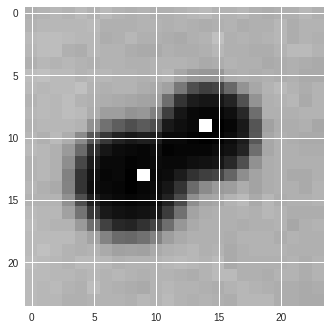

In [0]:
nImage = 16
image_copy = np.copy(train_images[nImage])
spot1 = descriptions.iloc[nImage, 1:3].values
spot2 = descriptions.iloc[nImage, 3:5].values
intensity = min( np.max(image_copy) + 20, 255)
if spot1[0] != 0 and spot1[1] != 0:
    image_copy[int(round(spot1[1]))][int(round(spot1[0]))] = intensity
if spot2[0] != 0 and spot2[1] != 0:
    image_copy[int(round(spot2[1]))][int(round(spot2[0]))] = intensity
plt.imshow(image_copy, cmap=plt.get_cmap('gray'))

In [0]:
def random_predict(images):
    """
    Return a DataFrame with a random pediciton for the `images` list.
    """
    rand_spot = np.random.randint(low = 0, high = 21, size = len(images))
    rand_location = np.random.random(len(images)) * 16 + 4
    answer =  pd.DataFrame(0, 
                           index=np.arange(len(images)), 
                           columns=["nb_spots", 
                                     "x_first_spot", "y_first_spot",
                                     "x_second_spot", "y_second_spot"])
    # Zero spot
    cond = (rand_spot) < 10
    answer.nb_spots[cond] = 0
    # One spot
    cond = (rand_spot >= 10) & (rand_spot < 20)
    answer.nb_spots[cond] = 1
    answer.x_first_spot[cond] = rand_location[cond]
    answer.y_first_spot[cond] = rand_location[cond]
    # Two spots
    cond = (rand_spot == 20)
    answer.nb_spots[cond] = 2
    answer.x_first_spot[cond] = rand_location[cond]
    answer.y_first_spot[cond] = rand_location[cond]
    answer.x_second_spot[cond] = rand_location[cond]
    answer.y_second_spot[cond] = rand_location[cond]
    return answer

In [0]:
train_prediction = random_predict(train_images)
train_prediction.groupby("nb_spots").mean()

,x_first_spot,y_first_spot,x_second_spot,y_second_spot
nb_spots,,,,
0,0.000000,0.000000,0.000000,0.000000
1,11.494896,11.494896,0.000000,0.000000
2,11.516867,11.516867,11.516867,11.516867


In [0]:
test_images = read_images("images_test.tiff")
test_prediction = random_predict(test_images)
test_prediction.groupby("nb_spots").mean()

,x_first_spot,y_first_spot,x_second_spot,y_second_spot
nb_spots,,,,
0,0.000000,0.000000,0.000000,0.000000
1,11.518428,11.518428,0.000000,0.000000
2,11.482404,11.482404,11.482404,11.482404


In [0]:
test_prediction.to_csv("answers.csv", header= False)

In [0]:
# function used to compute the score in the competition
## truth: the correct description of the spots
## observe: the compute description of the spots
def computeScore(truth, observe):
    alpha0 = 21/50.0
    alpha1 = 21/20.0
    alpha2 = 21*3/10
    assert len(truth) == len(observe)
    score = 0
    nb0 = 0
    nb1 = 0
    nb2 = 0
    for i in range(len(truth)):
        try :
            assert len(truth[i])==6
            assert len(observe[i])==6
        except:
            print(len(truth[i]))
            print(len(observe[i]))
            print(i)
            print("ERROR: the format of the file is wrong")
            return 1000000000000
        cur_truth = [int(truth[i][1]), float(truth[i][2]), float(truth[i][3]), float(truth[i][4]), float(truth[i][5])]
        cur_observe = [int(observe[i][1]), float(observe[i][2]), float(observe[i][3]), float(observe[i][4]), float(observe[i][5])]

        if cur_truth[0] == 0:
            score += alpha0 * f0(cur_truth, cur_observe)
            nb0 += 1
        elif cur_truth[0] == 1:
            score += alpha1 * f1(cur_truth, cur_observe)
            nb1 += 1
        elif cur_truth[0] == 2:
            score += alpha2 * f2(cur_truth, cur_observe)
            nb2 += 1
        else :
            score+=1
    return score/ (nb0 * alpha0 + nb1 * alpha1 + nb2 * alpha2)


# function to evaluate the score for image with zero spot
def f0(t, o):
    # print o[0]
    if o[0] == 0:
        return 0
    return 1

# function to evaluate the score for image with one spot
def f1(t,o):
    if o[0] == 0:
        return 1
    if o[0] == 1:
        return d(o[1],o[2],t[1],t[2])
    return ((1 + min(d(o[1], o[2], t[1], t[2]), d(o[3],o[4],t[1],t[2])))/ 2.0)

# function to evaluate the score for image with two spot
def f2(t,o):
    if o[0]==0:
        return 1
    if o[0] == 1:
        return ((1 + min(d(o[1], o[2], t[1], t[2]), d(o[1],o[2],t[3],t[4])))/ 2.0)
    return (min( d(o[1], o[2], t[1], t[2]) + d(o[3], o[4], t[3], t[4]) , d(o[1], o[2], t[3], t[4]) + d(o[3], o[4], t[1], t[2]) )/ 2.0)

# function of distance, evalue the quality of the detection
def d(x1, y1, x2, y2):
    dist = sqrt((x2-x1) * (x2-x1) + (y2-y1)*(y2-y1))
    if dist < 2:
        return ( (dist)/2.0)
    return 1

In [0]:
truth = descriptions.reset_index().values
find = train_prediction.reset_index().values
print(f'Score: {computeScore(truth, find)}')

Score: 0.8984613665914
